In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


In [2]:
# --- Load the prepared log returns ---
df = pd.read_csv('../data/processed/brent_log_returns.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
# --- Prepare data for modeling ---
returns = df['Log_Returns'].dropna().values
n = len(returns)

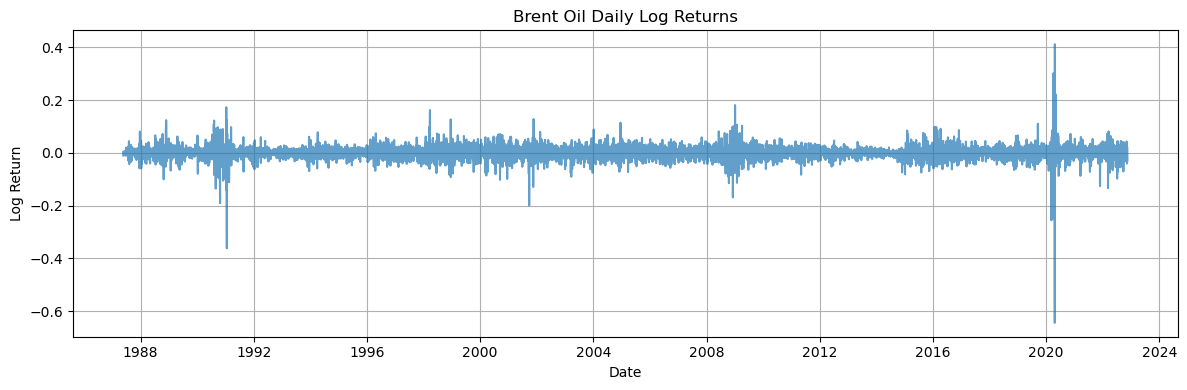

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(df['Date'].iloc[1:], returns, label='Log Returns', alpha=0.7)
plt.title('Brent Oil Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Bayesian change point model (1 switch point)
with pm.Model() as model:
    # Prior for the change point (discrete uniform over time index)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)

    # Priors for mean and std dev before and after the change
    mu_1 = pm.Normal('mu_1', mu=0, sigma=1)
    mu_2 = pm.Normal('mu_2', mu=0, sigma=1)

    sigma_1 = pm.HalfNormal('sigma_1', sigma=1)
    sigma_2 = pm.HalfNormal('sigma_2', sigma=1)

    # Switch based on tau
    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)
    sigma = pm.math.switch(tau >= np.arange(n), sigma_1, sigma_2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)

    # Sampling
    with model:
        step = pm.NUTS(target_accept=0.95)  # <-- fixes the ValueError
        trace = pm.sample(2000, tune=1000, step=step, return_inferencedata=True)

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_2, sigma_1, mu_2, mu_1]
>Metropolis: [tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 46 seconds.
The number of effective samples is smaller than 25% for some parameters.


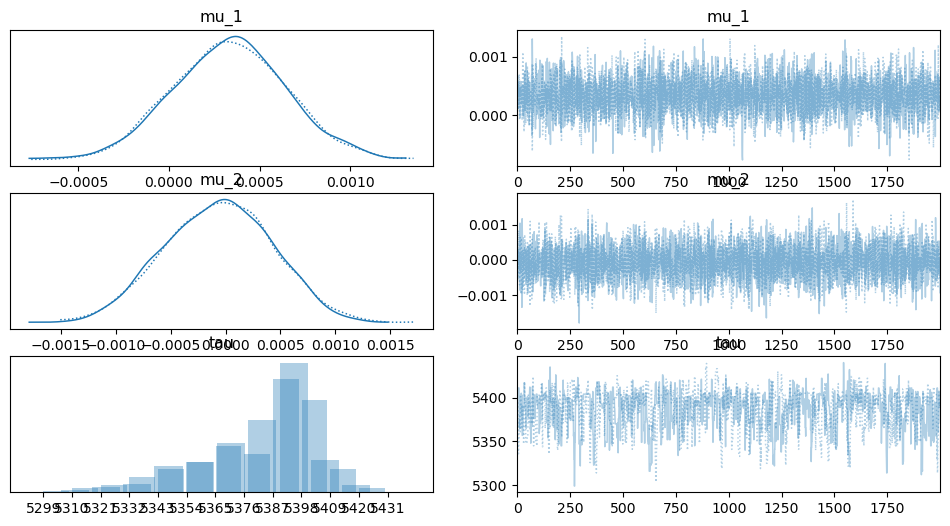

In [7]:
# Summary and convergence check
az.summary(trace, var_names=["mu_1", "mu_2", "sigma_1", "sigma_2", "tau"])

# Traceplot
az.plot_trace(trace, var_names=["mu_1", "mu_2", "tau"])
plt.show()

In [8]:
# Posterior of tau (change point)
tau_samples = trace.posterior['tau'].values.flatten()
tau_mean = int(np.mean(tau_samples))
print(f"Most probable change point (mean of posterior tau): {tau_mean}")
print(f"Corresponding date: {df.iloc[tau_mean]['Date'].date()}")

Most probable change point (mean of posterior tau): 5387
Corresponding date: 2008-07-24


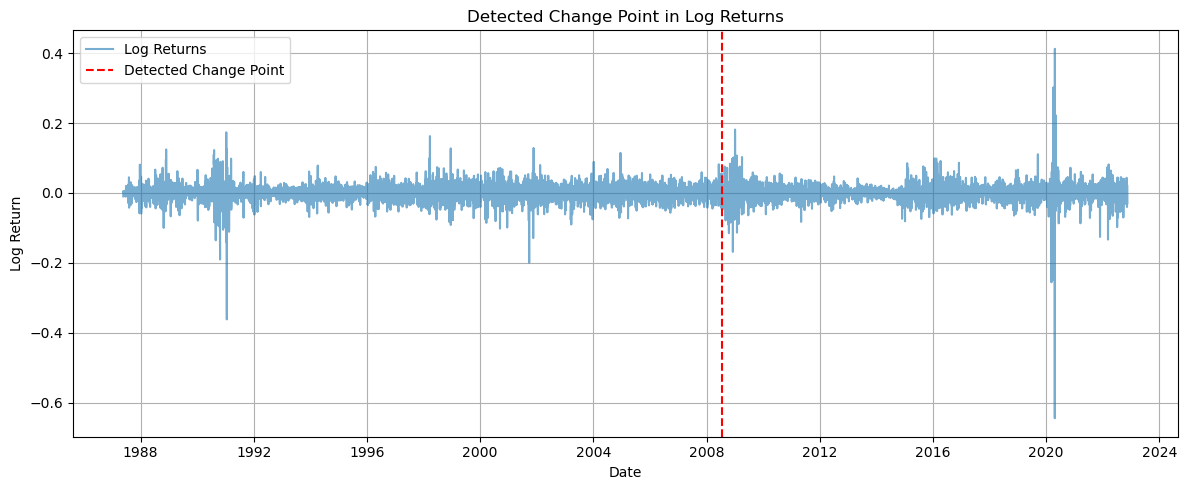

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df['Date'].iloc[1:], returns, label='Log Returns', alpha=0.6)
plt.axvline(df.iloc[tau_mean]['Date'], color='red', linestyle='--', label='Detected Change Point')
plt.title('Detected Change Point in Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
mu_1_samples = trace.posterior['mu_1'].values.flatten()
mu_2_samples = trace.posterior['mu_2'].values.flatten()

diff = mu_2_samples - mu_1_samples
print(f"Mean change in log returns: {np.mean(diff):.5f}")
print(f"Probability that mu_2 > mu_1: {(diff > 0).mean() * 100:.2f}%")

Mean change in log returns: -0.00040
Probability that mu_2 > mu_1: 24.98%


In [11]:
# --- Load key events to compare with change point ---
events_df = pd.read_csv('../data/key_events.csv')
events_df['Date'] = pd.to_datetime(events_df['Date'])

# Get the detected change point date
change_date = df.iloc[tau_mean]['Date']
window_days = 60  # look for events within ±60 days

# Find events within the time window
matching_events = events_df[
    (events_df['Date'] >= (change_date - pd.Timedelta(days=window_days))) &
    (events_df['Date'] <= (change_date + pd.Timedelta(days=window_days)))
]

# Mean returns before and after
mu1_mean = np.mean(mu_1_samples)
mu2_mean = np.mean(mu_2_samples)
percent_change = ((mu2_mean - mu1_mean) / abs(mu1_mean)) * 100

# Format and print interpretation
print("\n📘 Interpreting the Results")
print(f"Change Detected: {change_date.strftime('%B %Y')}")

if not matching_events.empty:
    print("Historical Match:")
    for _, row in matching_events.iterrows():
        print(f" - {row['Date'].date()}: {row['Event']}")
else:
    print("No major event found within ±60 days of the detected change point.")

# Summary sentence
direction = "increase" if percent_change > 0 else "decrease"
print("\nImpact Quantified:")
print(f"Following the event(s) around {change_date.strftime('%B %Y')}, the model detects a change point.")
print(f"The average daily log return shifted from {mu1_mean:.5f} to {mu2_mean:.5f}, a {abs(percent_change):.1f}% {direction}.")


📘 Interpreting the Results
Change Detected: July 2008
Historical Match:
 - 2008-09-15: Global Financial Crisis - Lehman Brothers Collapse

Impact Quantified:
Following the event(s) around July 2008, the model detects a change point.
The average daily log return shifted from 0.00033 to -0.00006, a 118.9% decrease.
